In [2]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0

     -------------------------------------- 438.0/438.0 MB 3.9 MB/s eta 0:00:00
     -------------------------------------- 438.0/438.0 MB 2.6 MB/s eta 0:00:00
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
     -------------------------------------- 462.5/462.5 kB 9.6 MB/s eta 0:00:00
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp310-cp310-win_amd64.whl (1.5 MB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0


In [3]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [7]:
!tar -xf lfw.tgz

In [22]:
 #Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [23]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [24]:
# Import uuid library to generate unique image names
import uuid

In [25]:
os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\582e1a2b-4f20-11ef-bc27-845cf3373f47.jpg'

In [26]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [27]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [28]:
dir_test = anchor.as_numpy_iterator()

In [29]:
print(dir_test.next())

b'data\\anchor\\07234d1e-4f0a-11ef-ab7f-845cf3373f47.jpg'


In [30]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [31]:
img = preprocess('data\\anchor\\ed66232f-4f09-11ef-9ec1-845cf3373f47.jpg')

In [32]:
img.numpy().max() 

1.0

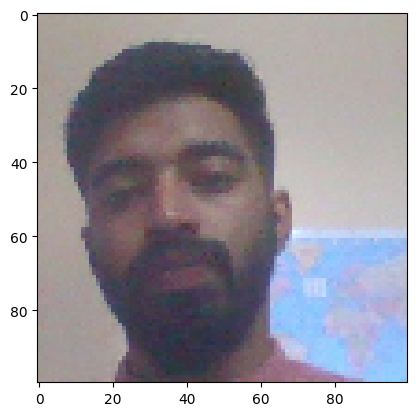

In [33]:
plt.imshow(img)

In [34]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [35]:
samples = data.as_numpy_iterator()

In [36]:
exampple = samples.next()

In [37]:
exampple

(b'data\\anchor\\0e72f5fa-4f0a-11ef-81ca-845cf3373f47.jpg',
 b'data\\positive\\60ec6377-4f0a-11ef-9601-845cf3373f47.jpg',
 1.0)

In [38]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [39]:
res = preprocess_twin(*exampple)

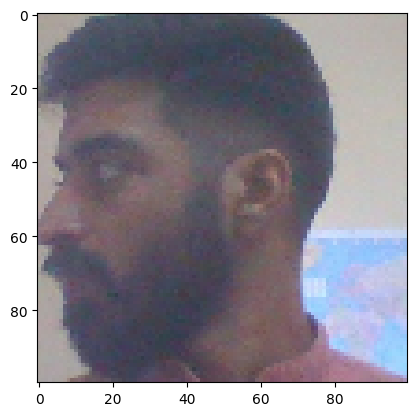

In [40]:
plt.imshow(res[1])

In [41]:
res[2]

1.0

In [42]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [43]:
samples=data.as_numpy_iterator()

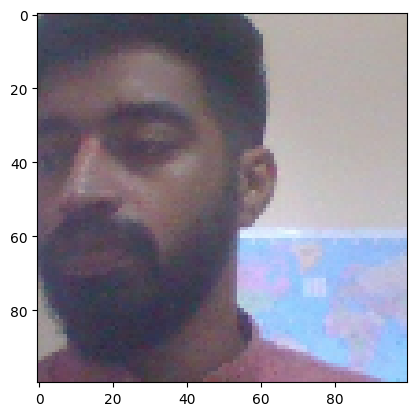

In [44]:
plt.imshow(samples.next()[0])

In [45]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [46]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [47]:
inp = Input(shape=(100,100,3), name='input_image')

In [48]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [49]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [50]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [51]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [52]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [53]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [54]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 128)       26

In [55]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [56]:
embedding = make_embedding()

In [57]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 17, 17, 128)       26

In [58]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [59]:
l1 = L1Dist()

In [60]:
l1

In [63]:
input_image=Input(name='input_img',shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [64]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [65]:
siamese_layer = L1Dist()

In [66]:
distances = siamese_layer(inp_embedding, val_embedding)

In [67]:
classifier = Dense(1, activation='sigmoid')(distances)

In [68]:
classifier


<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [69]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [70]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [71]:
def make_siamese_model():
    input_image=Input(name='input_img',shape=(100,100,3))
    validation_image=Input(name='validation_img',shape=(100,100,3))
    siamese_layer=L1Dist()
    siamese_layer._name='distance'
    distances= siamese_layer(embedding(input_image),embedding(validation_image))
     # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [72]:
siamese_model = make_siamese_model()

In [73]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [74]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [75]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [77]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [78]:
test_batch = train_data.as_numpy_iterator()

In [79]:
batch_1 = test_batch.next()

In [80]:
X = batch_1[:2]

In [81]:
y = batch_1[2]

In [82]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.],
      dtype=float32)

In [83]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [84]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [85]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [86]:
EPOCHS = 50

In [87]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
2/2 [==============================] - 46s 17s/step
0.6311275 0.0 0.0

 Epoch 2/50
2/2 [==============================] - 46s 21s/step
0.40873393 0.0 0.0

 Epoch 3/50
2/2 [==============================] - 46s 16s/step
0.17746274 0.0 0.0

 Epoch 4/50
2/2 [==============================] - 41s 16s/step
0.18258382 0.0 0.0

 Epoch 5/50
2/2 [==============================] - 41s 16s/step
0.07726447 0.0 0.0

 Epoch 6/50
2/2 [==============================] - 41s 14s/step
0.31687728 0.0 0.0

 Epoch 7/50
2/2 [==============================] - 34s 13s/step
0.2324082 0.0 0.0

 Epoch 8/50
2/2 [==============================] - 45s 16s/step
0.24066564 0.14285715 1.0

 Epoch 9/50
2/2 [==============================] - 47s 19s/step
0.14607558 0.16666667 1.0

 Epoch 10/50
2/2 [==============================] - 41s 15s/step
0.21408129 0

In [88]:
from tensorflow.keras.metrics import Precision, Recall

In [172]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [173]:
y_hat = siamese_model.predict([test_input, test_val])

In [174]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]

In [175]:
y_true

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.], dtype=float32)

In [176]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [177]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [178]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 1.0


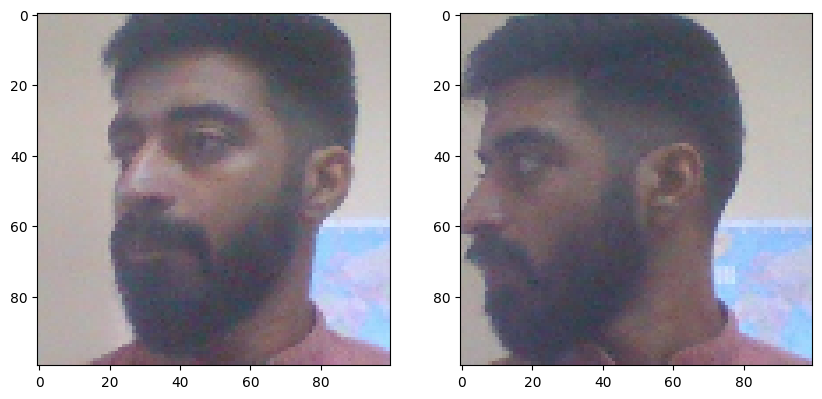

In [183]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[10])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[10])

# Renders cleanly
plt.show()

In [100]:
siamese_model.save('siamesemodelv2.h5')

In [101]:
L1Dist

__main__.L1Dist

In [102]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [103]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[8.4323710e-06],
       [3.0244848e-08],
       [3.4776036e-08],
       [8.1209873e-06],
       [7.0954447e-05],
       [7.2543969e-07],
       [9.9992281e-01],
       [2.6121184e-05],
       [9.9928606e-01],
       [9.9987411e-01],
       [1.0000000e+00]], dtype=float32)

In [104]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][